In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
import sys
from PIL import Image
import pandas as pd
import torch

sys.path.append('../../utils')
from plots import plot_bboxs
sys.path.append('../yolor')
from utils.general import xywh2xyxy, xyxy2xywh
from pathlib import Path

ModuleNotFoundError: No module named 'utils'

In [7]:
dir_2_label = '../yolor/open_pit_set-1/test/labels/'
dir_2_out   = '../yolor/'
files_label = [Path(dir_2_label, p) for p in sorted(os.listdir(dir_2_label))]
dir_2_predict = '../yolor/runs/detect/exp/labels'
dir_2_predict = '../yolov5/runs/val/exp39/labels'

files_predict = [Path(dir_2_predict,p) for p in sorted(os.listdir(dir_2_predict))]
files_images  = [Path('../yolor/open_pit_set-1/test/images', p) for p in sorted(os.listdir('../yolor/open_pit_set-2/test/images'))]

files_label = sorted(files_label, key = lambda x: x.parts[-1])
files_predict = sorted(files_predict, key = lambda x: x.parts[-1])
files_images = sorted(files_images, key = lambda x: x.parts[-1])

print(len(files_label), len(files_images), len(files_predict))

74 74 74


In [34]:
!rm -r ../image_files/bboxs/*

In [3]:
out_dir_root = '../image_files/bboxs_v5/'
for f_image in files_images:
    img = cv.imread(str(f_image))
    xx_label   = np.loadtxt(Path(dir_2_label, f_image.parts[-1].replace('.jpg','.txt')),dtype=np.float32)
    if len(xx_label.shape) == 1:
        xx_label = xx_label[np.newaxis]
    try:
        xx_predict = np.loadtxt(Path(dir_2_predict, f_image.parts[-1].replace('.jpg','.txt')),dtype=np.float32)
    except:
        xx_predict = np.zeros((1,5))
    if len(xx_predict.shape) == 1:
        xx_predict = xx_predict[np.newaxis]
    boxs_label = xywh2xyxy(xx_label[:, 1:])
    boxs_predict = xywh2xyxy(xx_predict[:,1:])
    img = plot_bboxs(img, boxs_label, color = [0,0,255], line_thickness = 6)
    img = plot_bboxs(img, boxs_predict, color = [0,128,0], line_thickness = 4, sline = cv.LINE_4)
    cv.imwrite(str(Path(out_dir_root,f_image.parts[-1])), img)  

In [4]:
def plot_bboxs(image, bboxs, color = None, line_thickness = None, sline = cv.LINE_AA):
    color = color or [255,0,0]
    tl = line_thickness or round(0.002 * (image.shape[0] + image.shape[1]) / 2) + 1  
    scale_h, scale_w = image.shape[:2]
    for bbox in bboxs:
        scale_x = bbox[[0, 2]]*scale_w
        scale_y = bbox[[1, 3]]*scale_h
        c1 = (int(scale_x[0]), int(scale_y[0]))
        c2 = (int(scale_x[1]), int(scale_y[1]))
        image = cv.rectangle(image, c1, c2, color, tl, lineType=sline)
    return image

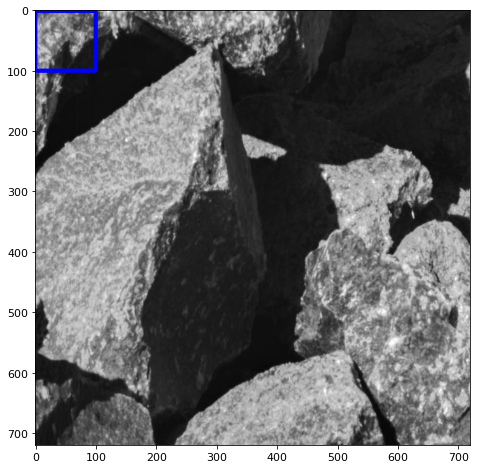

In [8]:
image = cv.imread(str(files_images[0]))
image = cv.rectangle(image, [1,2], [400,400], [0,0,255], 5, shift = 2)
fig = plt.figure(figsize=(8,8))
plt.imshow(image)